In [93]:
import pandas as pd
import numpy as np
import pickle

In [94]:
input_path = 'H:\RediMinds\VCQI'
train = pd.read_csv(input_path+"\VCQI_clean_train.csv")
test = pd.read_csv(input_path+"\VCQI_clean_test.csv")

In [95]:
x_train = train.drop(labels='INTRA_OP_COMPLICATIONS', axis = 'columns').copy()
y_train = train['INTRA_OP_COMPLICATIONS'].copy()
x_test = test.drop(labels='INTRA_OP_COMPLICATIONS', axis = 'columns').copy()
y_test = test['INTRA_OP_COMPLICATIONS'].copy() 

In [96]:
print('% pos labels train {:.2f}'.format(y_train.sum()/len(y_train)))
print('% pos labels test {:.2f}'.format(y_test.sum()/len(y_test)))

% pos labels train 0.05
% pos labels test 0.05


# Decision Tree Classifier

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
DTC = DecisionTreeClassifier()
parameter_dist = { 'max_features':['sqrt','log2',None],
                  'min_samples_leaf': [1,5,10,15,20,25,30,35,40,45,50], 
                  'class_weight' :[None,'balanced'], 
                  'random_state': [1234]}  
classifier_DTC = GridSearchCV(DTC, parameter_dist, n_jobs = -1, scoring = 'roc_auc', cv = 10 )
results_classifier_DTC = classifier_DTC.fit(x_train, y_train)
y_DTC = results_classifier_DTC.predict(x_test)


In [10]:
classifier = results_classifier_DTC
results_DTC = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_DTC['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_DTC['true_label'] = np.array(y_test)

In [11]:
# Decison Tree Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_DTC)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_DTC)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_DTC)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_DTC['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_DTC)))

{'class_weight': 'balanced', 'max_features': None, 'min_samples_leaf': 35, 'random_state': 1234}

 Model Best CV score: 
0.7815742579756944

 Model Balanced Accuracy: 
0.6954661016949153

 Confusion Matrix : 
[[690 254]
 [ 17  33]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       944
           1       0.11      0.66      0.20        50

    accuracy                           0.73       994
   macro avg       0.55      0.70      0.52       994
weighted avg       0.93      0.73      0.80       994


 AUC-ROC: 
0.7459427966101695

 PR-ROC: 
0.2345229294547213


In [13]:
def bootstrapped_AUC(result):
    from sklearn.utils import resample
    from tqdm import tqdm

    n_iter = 10000
    roc_auc = list()
    prc_auc = list()


    for i in range(n_iter):
        result_sample = resample(result, n_samples = len(result),random_state=i)
        
        #Calculating AUROC for each sample
        y_ACTUAL= result_sample['true_label']
        scores_prob = result_sample['pred_prob']
        fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
        roc_auc.append(metrics.auc(fpr, tpr))

        #calculate AUPRC for each sample
        y_ACTUAL = result_sample['true_label']
        scores_prob = result_sample['pred_prob']
        yhat = result_sample['pred_label']
        precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
        prc_auc.append(metrics.auc(recall,precision))
    
    return roc_auc, prc_auc

In [14]:
roc_auc_DTC, pr_auc_DTC = bootstrapped_AUC(results_DTC)

In [15]:
dict = {'roc_auc_DTC': roc_auc_DTC,
        'pr_auc_DTC': pr_auc_DTC,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_DTC,pr_auc_DTC
count,10000.000000,10000.000000
mean,0.746119,0.237975
std,0.038684,0.056353
min,0.553347,0.059228
2.5%,0.667040,0.135319
50%,0.746930,0.235215
97.5%,0.818022,0.353897
max,0.873930,0.509800


# Random Forest Classifier

In [97]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
RFC = RandomForestClassifier(random_state=42)
parameter_dist = {'n_estimators': [100,200,300,500], 'max_features':['sqrt','log2',None],
  'min_samples_leaf': [5,10,20,25,30,35,40,45,50], 'class_weight' :[None,'balanced'] 
}  
classifier_RFR = GridSearchCV(RFC, parameter_dist, n_jobs = -1,cv=10, scoring = 'roc_auc', return_train_score=True)
results_classifier_RFR = classifier_RFR.fit(x_train, y_train)


In [98]:
y_RFR = classifier_RFR.predict(x_test)
classifier = classifier_RFR
results_RFR = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_RFR['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_RFR['true_label'] = np.array(y_test)

In [99]:
# Random Forest Classifier Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_RFR)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_RFR)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_RFR)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_RFR['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_RFR)))

{'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 100}

 Model Best CV score: 
0.8419460959112282

 Model Balanced Accuracy: 
0.642521186440678

 Confusion Matrix : 
[[911  33]
 [ 34  16]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       944
           1       0.33      0.32      0.32        50

    accuracy                           0.93       994
   macro avg       0.65      0.64      0.64       994
weighted avg       0.93      0.93      0.93       994


 AUC-ROC: 
0.8544703389830509

 PR-ROC: 
0.3133359998836762


In [100]:
roc_auc_RFR, pr_auc_RFR = bootstrapped_AUC(results_RFR)

In [101]:
dict = {'roc_auc_RFR': roc_auc_RFR,
        'pr_auc_RFR': pr_auc_RFR,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_RFR,pr_auc_RFR
count,10000.000000,10000.000000
mean,0.854449,0.317596
std,0.023586,0.067608
min,0.747754,0.106713
2.5%,0.805204,0.189438
50%,0.855359,0.316686
97.5%,0.897989,0.451241
max,0.934492,0.602279


# Prepare data for Logistic Regression

In [102]:
# Create dummy variables
with open (input_path+'\cat_col', 'rb') as fp:
    cat_col = pickle.load(fp)


logit_train = train.copy()
for col in cat_col:
    if not col == 'INTRA_OP_COMPLICATIONS':
        logit_train = logit_train.merge(pd.get_dummies(logit_train[col], prefix=col), how = 'left', left_index = True, right_index =True) # create dummy variables
        logit_train = logit_train.drop(labels = col, axis = 'columns') # drop original variables

In [103]:
logit_train.head()

,AGE AT SURGERY,WEIGHT,HEIGHT,BMI,CLINICAL SIZE (mm),PRE-OP HB,PRE-OP HT,PRE-OP WBC,PRE-OP CREAT,PRE-OP EGFR,...,EXOPHYTIC/ENDOPHYTIC PROPERTIES_2,EXOPHYTIC/ENDOPHYTIC PROPERTIES_3,ANTERIOR OR POSTERIOR_0,ANTERIOR OR POSTERIOR_1,ANTERIOR OR POSTERIOR_2,ANTERIOR OR POSTERIOR_3,PARTIAL NEPHRO INDICATION_0,PARTIAL NEPHRO INDICATION_1,PARTIAL NEPHRO INDICATION_2,PARTIAL NEPHRO INDICATION_3
0,51.0,81.48,169.35,20.00,31.0,13.77,41.05,7640.82,0.74,111.508481,...,0,0,0,0,1,0,0,0,1,0
1,45.0,81.48,169.35,40.00,35.0,13.77,41.05,7640.82,2.79,18.349007,...,0,0,0,0,1,0,0,0,1,0
2,42.0,107.00,169.35,28.69,54.0,14.30,42.60,7640.82,1.30,80.510000,...,0,0,0,1,0,0,0,1,0,0
3,57.0,73.00,162.00,27.82,53.0,11.80,33.60,7600.00,1.80,39.090000,...,0,0,0,0,0,1,0,1,0,0
4,44.0,72.00,159.00,28.48,30.0,11.90,37.70,6160.00,0.80,77.920000,...,0,0,0,0,0,1,0,1,0,0


In [104]:
# Create dummy variables
with open (input_path+'\cat_col', 'rb') as fp:
    cat_col = pickle.load(fp)


logit_test = test.copy()
for col in cat_col:
    if not col == 'INTRA_OP_COMPLICATIONS':
        logit_test = logit_test.merge(pd.get_dummies(logit_test[col], prefix=col), how = 'left', left_index = True, right_index =True) # create dummy variables
        logit_test = logit_test.drop(labels = col, axis = 'columns') # drop original variables

In [105]:
logit_test.head()

,AGE AT SURGERY,WEIGHT,HEIGHT,BMI,CLINICAL SIZE (mm),PRE-OP HB,PRE-OP HT,PRE-OP WBC,PRE-OP CREAT,PRE-OP EGFR,...,EXOPHYTIC/ENDOPHYTIC PROPERTIES_2,EXOPHYTIC/ENDOPHYTIC PROPERTIES_3,ANTERIOR OR POSTERIOR_0,ANTERIOR OR POSTERIOR_1,ANTERIOR OR POSTERIOR_2,ANTERIOR OR POSTERIOR_3,PARTIAL NEPHRO INDICATION_0,PARTIAL NEPHRO INDICATION_1,PARTIAL NEPHRO INDICATION_2,PARTIAL NEPHRO INDICATION_3
0,54.0,76.00,153.00,32.47,25.0,13.00,38.00,7260.00,1.2,63.09,...,0,0,0,0,0,1,0,1,0,0
1,76.0,72.70,163.00,27.36,66.0,13.10,41.20,9600.00,1.3,53.67,...,0,0,1,0,0,0,0,1,0,0
2,48.0,90.00,164.00,33.46,25.0,14.60,43.40,5900.00,0.7,95.00,...,0,1,0,1,0,0,0,1,0,0
3,48.0,81.48,169.35,27.50,25.0,13.77,41.05,7640.82,0.8,81.00,...,0,0,0,0,1,0,0,0,1,0
4,82.0,71.00,175.00,23.18,3.6,13.50,38.30,4700.00,1.1,64.09,...,0,0,0,0,0,1,0,1,0,0


In [106]:
x_train = logit_train.drop(labels='INTRA_OP_COMPLICATIONS', axis = 'columns').copy()
y_train = logit_train['INTRA_OP_COMPLICATIONS'].copy()
x_test = logit_test.drop(labels='INTRA_OP_COMPLICATIONS', axis = 'columns').copy()
y_test = logit_test['INTRA_OP_COMPLICATIONS'].copy()

In [107]:
print("Number of records in trainset {}".format(len(x_train)))
print("Number records in testset {}".format(len(x_test)))
print('% pos labels train {:.2f}'.format(y_train.sum()/len(y_train)))
print('% pos labels test {:.2f}'.format(y_test.sum()/len(y_test)))

Number of records in trainset 2318
Number records in testset 994
% pos labels train 0.05
% pos labels test 0.05


In [108]:
x_train.describe()

,AGE AT SURGERY,WEIGHT,HEIGHT,BMI,CLINICAL SIZE (mm),PRE-OP HB,PRE-OP HT,PRE-OP WBC,PRE-OP CREAT,PRE-OP EGFR,...,EXOPHYTIC/ENDOPHYTIC PROPERTIES_2,EXOPHYTIC/ENDOPHYTIC PROPERTIES_3,ANTERIOR OR POSTERIOR_0,ANTERIOR OR POSTERIOR_1,ANTERIOR OR POSTERIOR_2,ANTERIOR OR POSTERIOR_3,PARTIAL NEPHRO INDICATION_0,PARTIAL NEPHRO INDICATION_1,PARTIAL NEPHRO INDICATION_2,PARTIAL NEPHRO INDICATION_3
count,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,...,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000
mean,57.846255,81.557647,169.353568,28.699550,32.994694,13.775677,41.093227,7640.550768,0.971262,80.536584,...,0.093615,0.181191,0.327869,0.203192,0.141070,0.327869,0.028473,0.580673,0.285160,0.105695
std,12.518291,15.558921,9.186605,5.472589,16.289654,1.586341,4.187216,2305.989550,0.404543,21.176050,...,0.291355,0.385259,0.469538,0.402461,0.348169,0.469538,0.166355,0.493555,0.451588,0.307513
min,16.000000,7.711150,105.000000,15.100000,0.000000,1.300000,1.800000,1060.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,73.487025,166.000000,25.000000,22.000000,13.200000,40.200000,6700.000000,0.780000,70.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,59.000000,81.480000,169.350000,28.390000,32.000000,13.770000,41.050000,7640.820000,0.920000,80.510000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,67.000000,85.275000,173.000000,31.140000,40.000000,14.500000,42.700000,7648.455000,1.090000,88.990000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,89.000000,171.000000,208.300000,50.000000,135.000000,39.600000,88.000000,56000.000000,9.740000,253.971416,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [109]:
x_test.describe()

,AGE AT SURGERY,WEIGHT,HEIGHT,BMI,CLINICAL SIZE (mm),PRE-OP HB,PRE-OP HT,PRE-OP WBC,PRE-OP CREAT,PRE-OP EGFR,...,EXOPHYTIC/ENDOPHYTIC PROPERTIES_2,EXOPHYTIC/ENDOPHYTIC PROPERTIES_3,ANTERIOR OR POSTERIOR_0,ANTERIOR OR POSTERIOR_1,ANTERIOR OR POSTERIOR_2,ANTERIOR OR POSTERIOR_3,PARTIAL NEPHRO INDICATION_0,PARTIAL NEPHRO INDICATION_1,PARTIAL NEPHRO INDICATION_2,PARTIAL NEPHRO INDICATION_3
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,...,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,57.896097,81.292020,169.349738,28.678806,32.281610,13.747243,40.958602,7641.444024,0.970523,80.442150,...,0.116700,0.179074,0.334004,0.197183,0.146881,0.321932,0.024145,0.589537,0.289738,0.096579
std,12.885752,16.290823,9.298550,5.485804,15.718635,1.422368,3.774225,2246.207077,0.323912,20.672407,...,0.321224,0.383608,0.471879,0.398072,0.354166,0.467452,0.153576,0.492165,0.453869,0.295533
min,17.000000,42.000000,112.000000,16.120000,0.000000,4.780000,24.800000,3000.000000,0.360000,14.459734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,72.475000,166.000000,25.000000,22.000000,13.200000,40.200000,6700.000000,0.780000,69.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,59.000000,81.480000,169.350000,28.690000,32.000000,13.770000,41.050000,7640.820000,0.920000,80.510000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,67.000000,85.000000,173.750000,31.009450,40.000000,14.500000,42.500000,7640.820000,1.100000,88.049979,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,89.000000,172.370000,211.000000,49.130000,107.000000,19.700000,57.200000,39200.000000,4.120000,202.815628,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


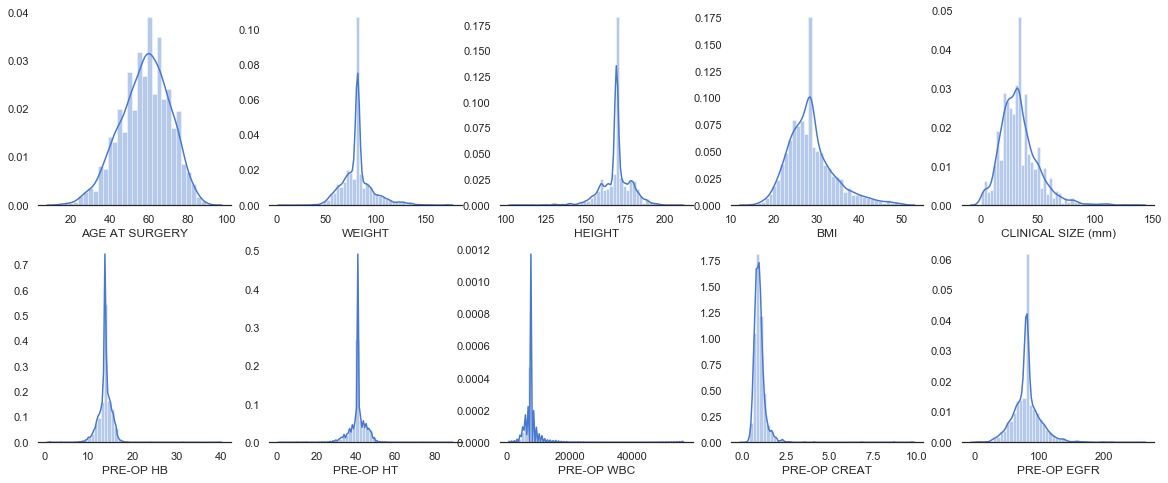

In [110]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)
f, axes = plt.subplots(2, 5, figsize=(20, 8))
sns.despine(left=True)
# Plot a simple histogram with binsize determined automatically
sns.distplot(x_train['AGE AT SURGERY'], ax=axes[0, 0])
sns.distplot(x_train['WEIGHT'], ax=axes[0, 1])
sns.distplot(x_train['HEIGHT'],ax=axes[0,2])
sns.distplot(x_train['BMI'], ax=axes[0,3])
sns.distplot(x_train['CLINICAL SIZE (mm)'], ax=axes[0, 4])
sns.distplot(x_train['PRE-OP HB'], ax=axes[1, 0])
sns.distplot(x_train['PRE-OP HT'], ax=axes[1, 1])
sns.distplot(x_train['PRE-OP WBC'], ax=axes[1, 2])
sns.distplot(x_train['PRE-OP CREAT'],ax=axes[1,3])
sns.distplot(x_train['PRE-OP EGFR'], ax=axes[1,4])


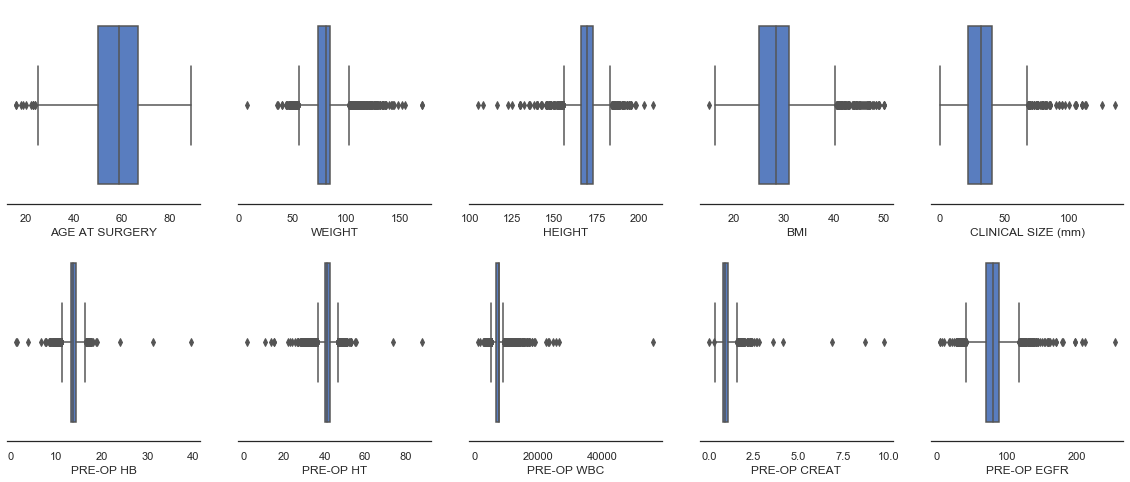

In [111]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)
f, axes = plt.subplots(2, 5, figsize=(20, 8))
sns.despine(left=True)
# Plot a simple histogram with binsize determined automatically
sns.boxplot(x_train['AGE AT SURGERY'], ax=axes[0, 0])
sns.boxplot(x_train['WEIGHT'], ax=axes[0, 1])
sns.boxplot(x_train['HEIGHT'],ax=axes[0,2])
sns.boxplot(x_train['BMI'], ax=axes[0,3])
sns.boxplot(x_train['CLINICAL SIZE (mm)'], ax=axes[0, 4])
sns.boxplot(x_train['PRE-OP HB'], ax=axes[1, 0])
sns.boxplot(x_train['PRE-OP HT'], ax=axes[1, 1])
sns.boxplot(x_train['PRE-OP WBC'], ax=axes[1, 2])
sns.boxplot(x_train['PRE-OP CREAT'],ax=axes[1,3])
sns.boxplot(x_train['PRE-OP EGFR'], ax=axes[1,4])


In [112]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [113]:
numeric_features = x_train.select_dtypes('float').columns.tolist()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)], remainder='passthrough')

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
model = LogisticRegression()
parameter_dist = {'classifier__solver':['saga','liblinear','newton-cg','lbfgs'],
                  'classifier__penalty':['l2'],
                  'classifier__max_iter':[10000],
                  'classifier__class_weight':[None, 'balanced'],
                  'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
                 }



clf = Pipeline(steps=[('preprocessor', preprocessor),
                      #('pca',PCA()),
                      ('classifier', LogisticRegression(random_state = 42))])
logit = GridSearchCV(clf,parameter_dist,n_jobs=-1,scoring= 'roc_auc', cv = 10)

In [123]:
#train and fit to original data
classifier_logit = logit.fit(x_train, y_train)
y_logit = classifier_logit.predict(x_test)

In [124]:
classifier = classifier_logit
results_logit = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_logit['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_logit['true_label'] = np.array(y_test)

In [125]:
# Logistic Regression Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_logit)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_logit)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_logit)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_logit['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_logit)))

{'classifier__C': 1, 'classifier__class_weight': None, 'classifier__max_iter': 10000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

 Model Best CV score: 
0.8379855835852384

 Model Balanced Accuracy: 
0.5535169491525423

 Confusion Matrix : 
[[894  50]
 [ 42   8]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       944
           1       0.14      0.16      0.15        50

    accuracy                           0.91       994
   macro avg       0.55      0.55      0.55       994
weighted avg       0.91      0.91      0.91       994


 AUC-ROC: 
0.7088135593220339

 PR-ROC: 
0.16817631334459038


In [126]:
roc_auc_logit, pr_auc_logit = bootstrapped_AUC(results_logit)

In [127]:
dict = {'roc_auc_logit': roc_auc_logit,
        'pr_auc_logit': pr_auc_logit,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_logit,pr_auc_logit
count,10000.000000,10000.000000
mean,0.708826,0.171019
std,0.037200,0.048294
min,0.574984,0.043215
2.5%,0.632640,0.084711
50%,0.709768,0.168194
97.5%,0.778900,0.271421
max,0.848216,0.386456


# Compare Classifiers

H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


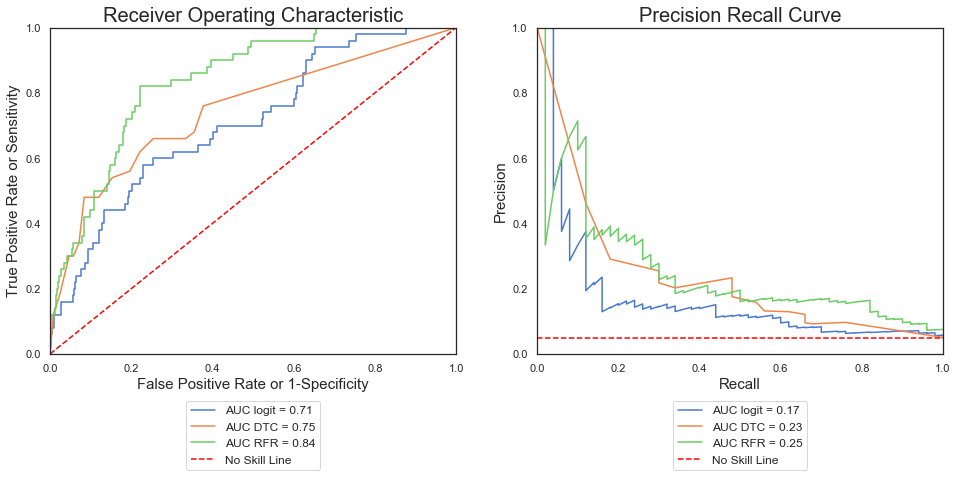

In [72]:
# Plotting AUROC Curve - Calculatae Metrics
from sklearn import metrics
def calc_aucroc_data(result):
    y_ACTUAL= result['true_label']
    scores_prob = result['pred_prob']
    fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    f1 = metrics.f1_score(y_ACTUAL, yhat)
    ap = metrics.average_precision_score(y_ACTUAL, yhat)
    postives_ratio = round(sum(result['true_label'])/(len(result['true_label'])),2)
    return recall, precision, f1, prc_auc, postives_ratio

fpr_logit, tpr_logit, thresholds_logit, roc_auc_logit = calc_aucroc_data(results_logit)
recall_logit, precision_logit, f1_logit, prc_auc_logit, postives_ratio_logit = calc_aucpr_data(results_logit)

fpr_DTC, tpr_DTC, thresholds_DTC, roc_auc_DTC = calc_aucroc_data(results_DTC)
recall_DTC, precision_DTC, f1_DTC, prc_auc_DTC, postives_ratio_DTC = calc_aucpr_data(results_DTC)

fpr_RFR, tpr_RFR, thresholds_RFR, roc_auc_RFR = calc_aucroc_data(results_RFR)
recall_RFR, precision_RFR, f1_RFR, prc_auc_RFR, postives_ratio_RFR = calc_aucpr_data(results_RFR)


import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))

# Plotting AUROC Curve - Plot Curve
ax1.set_title('Receiver Operating Characteristic',fontdict={"size":20})
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate or Sensitivity', fontdict={"size":15})
ax1.set_xlabel('False Positive Rate or 1-Specificity',fontdict={"size":15})
ax1.plot(fpr_logit, tpr_logit, label = 'AUC logit = %0.2f' % roc_auc_logit)
ax1.plot(fpr_DTC, tpr_DTC, label = 'AUC DTC = %0.2f' % roc_auc_DTC)
ax1.plot(fpr_RFR, tpr_RFR, label = 'AUC RFR = %0.2f' % roc_auc_RFR)
ax1.plot([0, 1], [0, 1],linestyle='--',color='red', label = 'No Skill Line')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), fontsize = 12)  

# Plotting Precision-Recall Curve - PLot Curve
ax2.set_title('Precision Recall Curve',fontdict={"size":20})
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('Precision',fontdict={"size":15})
ax2.set_xlabel('Recall',fontdict={"size":15})
ax2.plot(recall_logit, precision_logit, label = 'AUC logit = %.2f' % (prc_auc_logit))
ax2.plot(recall_DTC, precision_DTC, label = 'AUC DTC = %.2f' % (prc_auc_DTC))
ax2.plot(recall_RFR, precision_RFR, label = 'AUC RFR = %.2f' % (prc_auc_RFR))
positive_class_ratio = postives_ratio_logit
ax2.plot([0, 1], [positive_class_ratio, positive_class_ratio],linestyle='--',color='red', label = 'No Skill Line')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)

fig.show()



In [128]:
output_path = 'output/models'

In [129]:
import os
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [130]:
# Export Decision Tree Classifier with Pipeline
from joblib import dump
dump(classifier_DTC, output_path+'/DTC.joblib')

['output/models/DTC.joblib']

In [131]:
# Export Random Forest Classifer with Pipeline
from joblib import dump
dump(classifier_RFR, output_path+'/RFR.joblib')

['output/models/RFR.joblib']

In [132]:
# Export Random Forest Classifer with Pipeline
from joblib import dump
dump(classifier_logit, output_path+'/Logit.joblib')

['output/models/Logit.joblib']